In [40]:
from arcade_dataset import load_dataset, visualize_batch
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision.utils import make_grid
import torch
from torch.utils.data import DataLoader
import wandb
import numpy as np
from PIL import Image
import os

In [41]:
if not os.path.exists('plots'):
    os.makedirs('plots')

In [42]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

### Label Distribution

In [43]:
label_dist_split = 'train'

In [44]:
train_dataset = load_dataset(label_dist_split)

In [45]:
# Plot a grid of the mean label, for each label
label_means = torch.zeros_like(train_dataset[0]['separate_masks'])
for i in range(len(train_dataset)):
    label_means += train_dataset[i]['separate_masks']
label_means /= len(train_dataset)

In [46]:
labels_grid = make_grid(label_means.unsqueeze(1), nrow=5, normalize=True, scale_each=True).permute(1, 2, 0)

In [47]:
H_cell, W_cell = labels_grid.size(0) // 5, labels_grid.size(1) // 5 
grid_size = 5

def create_hued_square(hue, height, width):
    # Create an image with the given hue
    img = Image.new('HSV', (width, height), (int(hue), 255, 255))
    img = img.convert('RGB')
    return np.array(img).transpose(2, 0, 1)

# Create a list of hued squares
squares = []
for i in range(grid_size * grid_size):
    hue = (i / (grid_size * grid_size)) * 200 # Distribute hues evenly
    square = create_hued_square(hue, H_cell, W_cell)
    squares.append(square)

# Convert list of squares to a tensor
squares_tensor = torch.tensor(squares)

# Create the grid
color_grid = torch.tensor(make_grid(squares_tensor, nrow=grid_size).numpy().transpose(1, 2, 0))
color_grid = color_grid[:labels_grid.size(0), :labels_grid.size(1)]

In [48]:
color_grid.size(), labels_grid.mean(-1).unsqueeze(-1).size()

(torch.Size([2572, 2572, 3]), torch.Size([2572, 2572, 1]))

In [49]:
color_grid = color_grid / 255.0

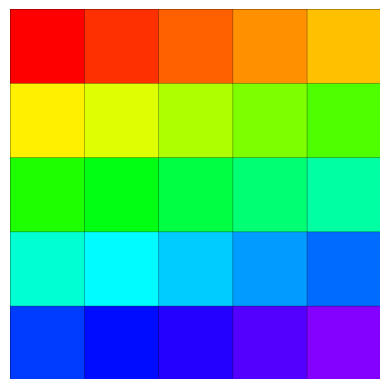

In [50]:
plt.imshow(color_grid)
plt.axis('off')
plt.show()

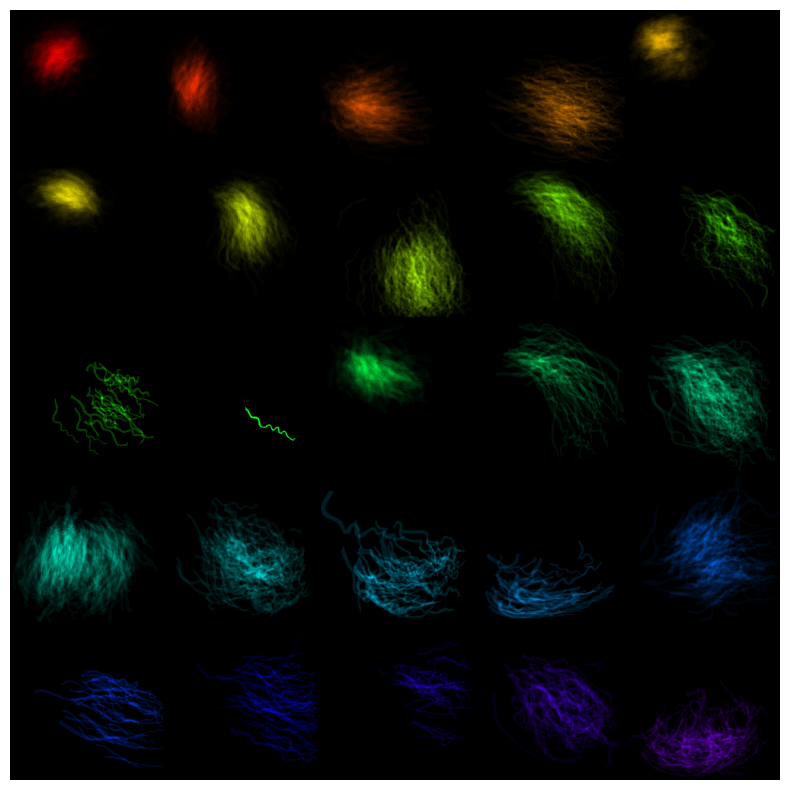

In [51]:
plt.figure(figsize=(10, 10))
plt.imshow(labels_grid.mean(-1).unsqueeze(-1) * color_grid)
plt.axis('off')
plt.savefig('plots/vessel_distribution_{label_dist_split}.svg', format='svg', bbox_inches='tight')
plt.show()

### Visualize Batch

In [52]:
dataset = load_dataset(split='val')
next(iter(dataset)).keys()
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
batch = next(iter(dataloader))

In [53]:
batch['original_image'].max(), batch['original_image'].min()

(tensor(255.), tensor(0.))

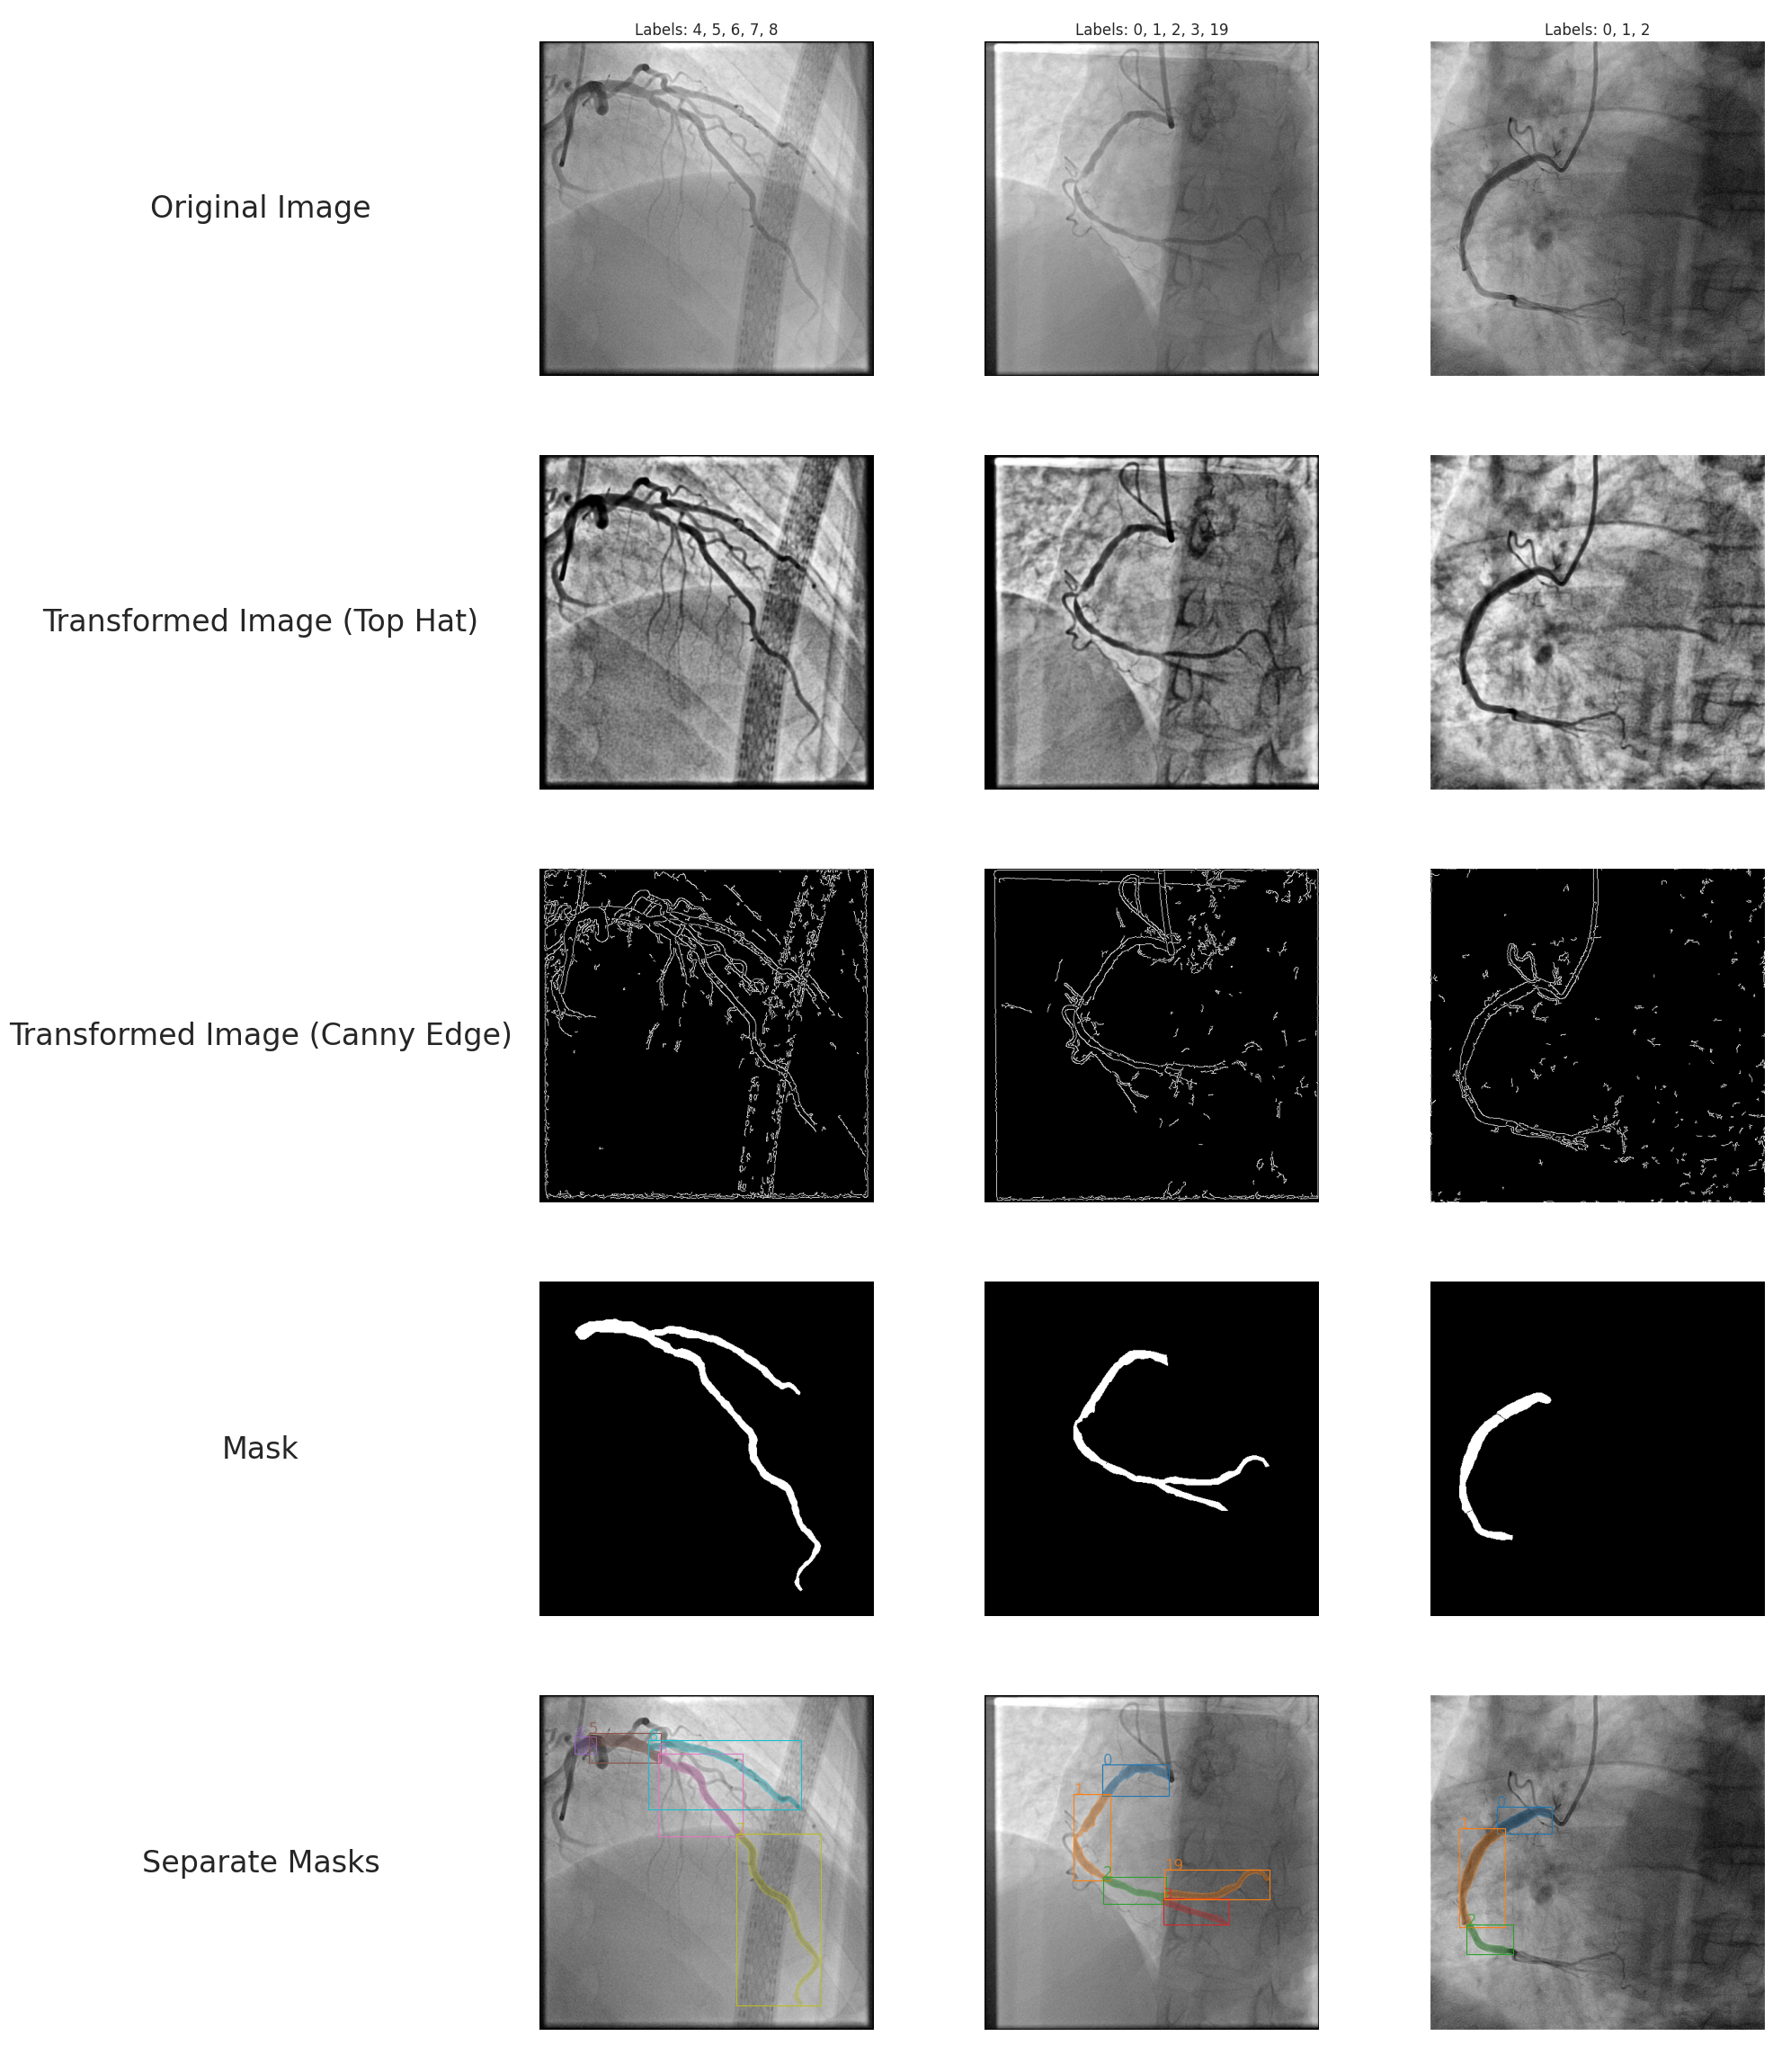

In [54]:
visualize_batch(batch, num_classes=25, num_images=3)
plt.savefig('plots/sample_batch.svg', format='svg', bbox_inches='tight')
plt.show()

### Label Distributions

In [55]:
datasets = {
    'train': (load_dataset('train'), 'r'),
    'val': (load_dataset('val'), 'g'),
    'test': (load_dataset('test'), 'b')
}

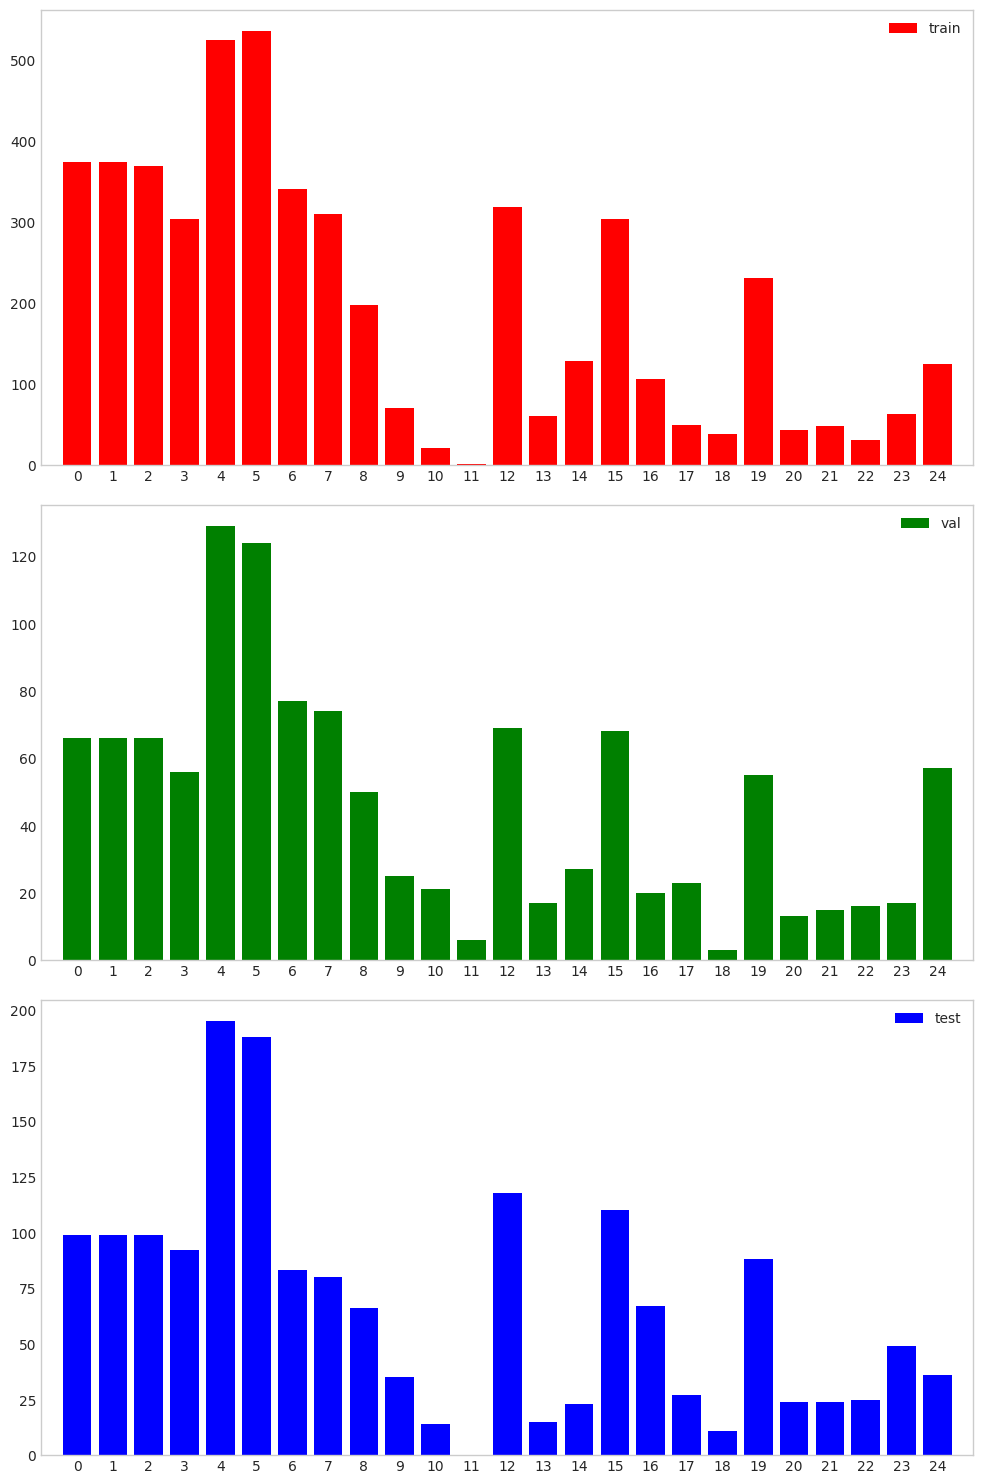

In [56]:
plt.subplots(3, 1, figsize=(10, 15))
plt.tight_layout()

for i, (split, (dataset, color)) in enumerate(datasets.items()):
    all_labels = [torch.where(x['labels'] > 0.5)[0] for x in dataset]
    all_labels = torch.cat(all_labels, dim=0)
    plt.subplot(3, 1, i + 1)
    plt.bar(*torch.unique(all_labels, return_counts=True), color=color, label=split)
    plt.xticks(range(25))
    plt.legend()
    plt.xlim(-1, 25)
    plt.gca().grid(False)
    plt.savefig('plots/label_distribution.svg', format='svg', bbox_inches='tight')
plt.show()

### Val F1 Lines

In [57]:
api = wandb.Api()
sweep = api.sweep('nlp-course-zvi-and-tomer/DMI-2024/sweeps/nqyqzk32')
f1_s = []
for run in sweep.runs:
    if run.state == 'finished':
        f1_s.append(run.scan_history(['val_f1']))
f1_s = [[f1['val_f1'] for f1 in f1]
        for f1 in f1_s if f1 is not None]

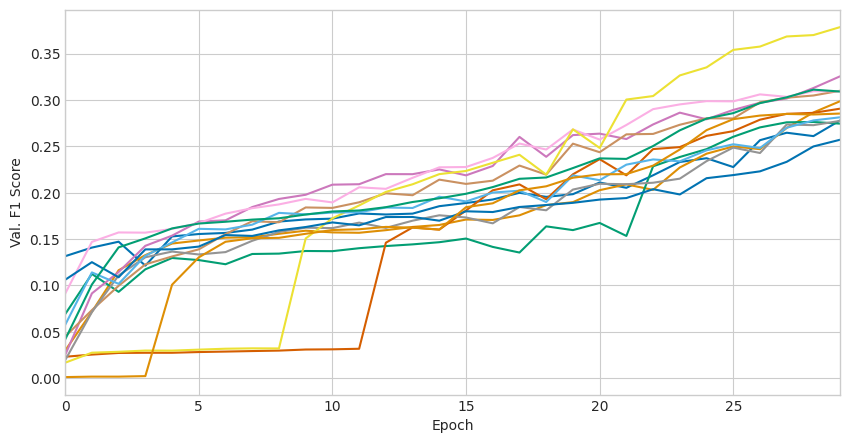

In [58]:
plt.figure(figsize=(10, 5))
plt.xlim(0, 29)
for f1 in f1_s:
    plt.plot(f1)
plt.xlabel('Epoch')
plt.ylabel('Val. F1 Score')
plt.savefig('plots/sweep_f1.svg', format='svg', bbox_inches='tight')
plt.show()

### Full Run Loss Exploration

In [59]:
best_run = 'oxwn02hh' # CHANGE THIS TO THE BEST RUN ID
run = api.run(f"nlp-course-zvi-and-tomer/DMI2024B/runs/{best_run}")
val_f1 = run.scan_history(keys=['val_f1'])
train_loss = run.scan_history(keys=['train_loss'])
val_loss = run.scan_history(keys=['val_loss'])
reconstruction_loss = run.scan_history(keys=['reconstruction_loss'])
lr = run.scan_history(keys=['lr-Adam'])

In [60]:
val_f1 = [x['val_f1'] for x in val_f1]
train_loss = [x['train_loss'] for x in train_loss]
val_loss = [x['val_loss'] for x in val_loss]
reconstruction_loss = [x['reconstruction_loss'] for x in reconstruction_loss]
lr = [x['lr-Adam'] for x in lr]

In [61]:
# Smooth losses
def smooth(x, window=5):
    return pd.Series(x).rolling(window=window).mean()

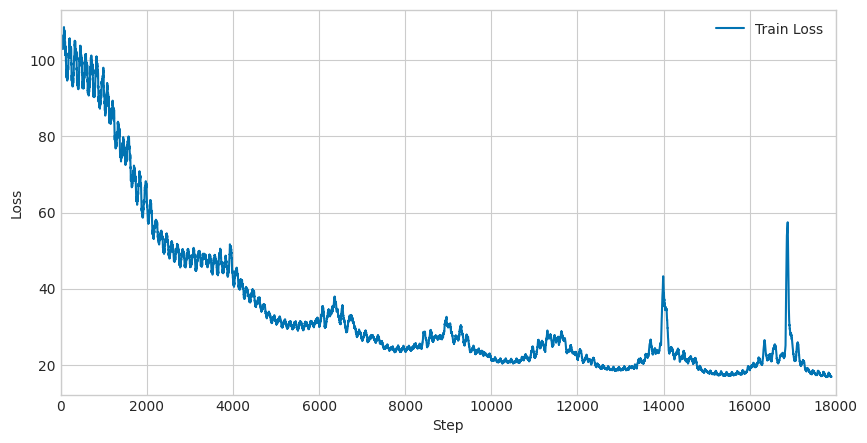

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(smooth(train_loss[1000:-2000], 50), label='Train Loss')
plt.xlim(0, 18000)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/train_loss.svg', format='svg', bbox_inches='tight')
plt.show()

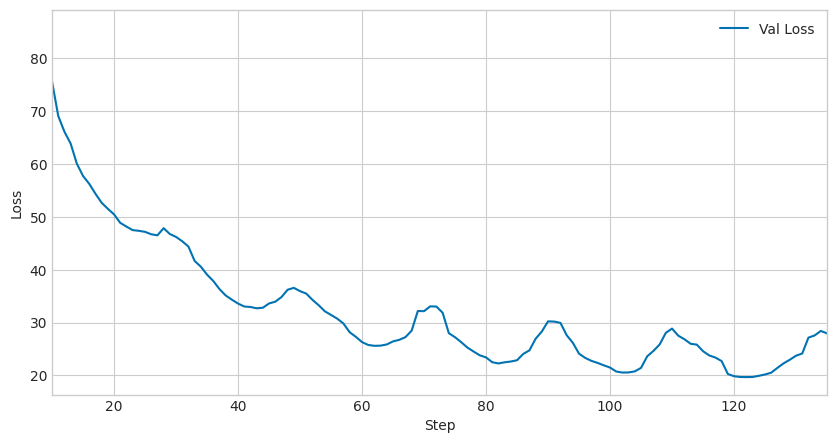

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(smooth(val_loss[10:-20], 5), label='Val Loss')
plt.xlim(10, 135)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/val_loss.svg', format='svg', bbox_inches='tight')
plt.show()

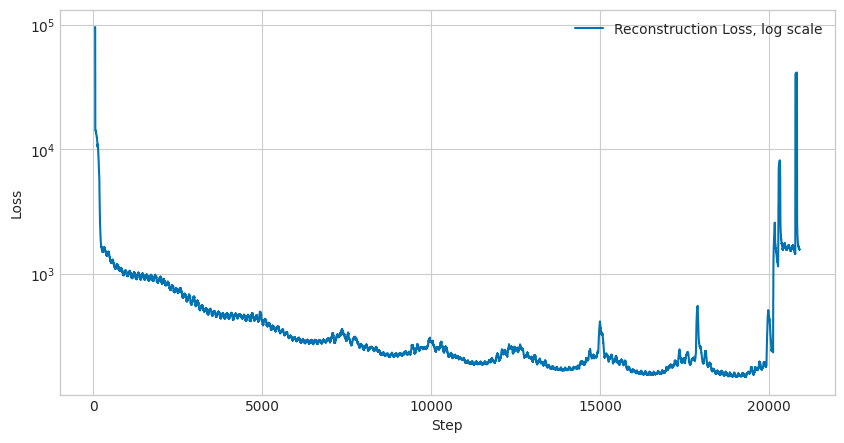

In [64]:
plt.figure(figsize=(10, 5))
plt.semilogy(smooth(reconstruction_loss, 50), label='Reconstruction Loss, log scale')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/reconstruction_loss.svg', format='svg', bbox_inches='tight')

### Model Convs Viz.

**Unfortunately, did not work :(**

In [65]:
# train_dataset = load_dataset('train')

In [66]:
# model = VesselSegmentationModel.load_from_checkpoint('models/final_model/oxwn02hh/epoch=152-step=19125.ckpt')
# model.eval()

In [67]:
# def extract_filter(model, block_idx, filter_idx):
#     filter = model.model.encoder.blocks[block_idx][0].block[-1].weight[filter_idx, 0]
#     return filter

In [68]:
# extract_filter(model, 4, 0).size()

In [69]:
# def loss(input_image, block_idx, filter_idx):
#     features = extract_filter(model, block_idx, filter_idx)
#     return -features.mean()

# def optimize(input_image, block_idx, filter_idx, n_steps=1000, lr=0.1):
#     input_image = input_image.clone().detach().requires_grad_(True)
#     optimizer = torch.optim.Adam([input_image], lr=lr)

#     for _ in tqdm(range(n_steps)):
#         optimizer.zero_grad()
#         l = loss(input_image, block_idx, filter_idx)
#         l.backward()
#         optimizer.step()
#         input_image.data.clamp_(0, 1)
#     return input_image

In [70]:
# img = train_dataset[0]['original_image'].to(model.device)

# # Optimize the input image to maximize the activation of the filter
# block_idx = 4
# fig, axs = plt.subplots(4, 4, figsize=(15, 15))
# for filter_idx in range(16):
#     optimized_img = optimize(img, block_idx, filter_idx, n_steps=100, lr=1e-2)
#     axs[filter_idx // 4, filter_idx % 4].imshow(optimized_img.squeeze().detach().cpu().numpy(), cmap='gray')
#     axs[filter_idx // 4, filter_idx % 4].axis('off')
# plt.savefig('plots/filter_activation_maximization_visualization.svg', format='svg', bbox_inches='tight')
# plt.show()